##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [46]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [47]:
orig_df = pd.read_csv("C:/Users/pavan kumar/Downloads/LVMPD-Stats.csv", parse_dates=['ReportedOn'])


In [115]:
df = pd.read_csv("C:/Users/pavan kumar/Downloads/LVMPD-Stats.csv", parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [116]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [117]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [118]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [119]:
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


## Data Column Explanations

- **X and Y**: These columns likely represent spatial coordinates or positions.

- **Time**: This column appears to represent time-related data. However, since it's factorized, we don't have the original values, making it hard to interpret.

- **DayOfWeek**: Similar to 'Time', it seems to represent days of the week but is also factorized, making interpretation difficult.

- **Area_Command**: This column is factorized and likely represents different administrative areas or commands.

- **VictimCount**: Factorized, likely representing the count of victims in an incident.

- **NIBRSOffenseCode**: Also factorized, indicating different types of criminal offenses using NIBRS codes.


In [120]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


In [121]:
# Calculate the range of values for each column
range_X = df['X'].max() - df['X'].min()
range_Y = df['Y'].max() - df['Y'].min()
range_Time = df['Time'].max() - df['Time'].min()
range_DayOfWeek = df['DayOfWeek'].max() - df['DayOfWeek'].min()
range_Area_Command = df['Area_Command'].max() - df['Area_Command'].min()
range_VictimCount = df['VictimCount'].max() - df['VictimCount'].min()
range_NIBRSOffenseCode = df['NIBRSOffenseCode'].max() - df['NIBRSOffenseCode'].min()

print(f"Range of values for X: {range_X}")
print(f"Range of values for Y: {range_Y}")
print(f"Range of values for Time: {range_Time}")
print(f"Range of values for DayOfWeek: {range_DayOfWeek}")
print(f"Range of values for Area_Command: {range_Area_Command}")
print(f"Range of values for VictimCount: {range_VictimCount}")
print(f"Range of values for NIBRSOffenseCode: {range_NIBRSOffenseCode}")


Range of values for X: 1.374429500000005
Range of values for Y: 1.9315810000000013
Range of values for Time: 23
Range of values for DayOfWeek: 6
Range of values for Area_Command: 11
Range of values for VictimCount: 6
Range of values for NIBRSOffenseCode: 2


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [122]:
import torch
from torch.utils.data import DataLoader, TensorDataset

input_data = torch.randn(100, 5)  # 100 samples, 5 features
output_data = torch.randn(100, 1)  # 100 samples, 1 output

# Spliting the data  into training and testing datasets
split_ratio = 0.8
split_index = int(len(input_data) * split_ratio)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the  batch size as 32.
batch_size = 32

# Creating the  DataLoader objects for training and testing
train_dataset = TensorDataset(train_input, train_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input, test_output)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Printing the shapes for verification.
for batch_input, batch_output in train_dataloader:
    print("Batch Input Shape:", batch_input.shape)
    print("Batch Output Shape:", batch_output.shape)
    break #shape of first batch.



Batch Input Shape: torch.Size([32, 5])
Batch Output Shape: torch.Size([32, 1])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [123]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


input_size = 5  
hidden_size = 64  
batch_size = 32
learning_rate = 0.001
num_epochs = 100  s


class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()  
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 1)  # Output size is 1 for regression

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(train_input, train_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input, test_output)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the regression model
model = RegressionModel(input_size, hidden_size)

# Define the Mean Squared Error (MSE) loss
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_input, batch_output in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients
        predicted_output = model(batch_input)
        loss = criterion(predicted_output, batch_output)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

    # Calculate MSE on the test data after each epoch
    with torch.no_grad():
        total_loss = 0
        for batch_input, batch_output in test_dataloader:
            predicted_output = model(batch_input)
            test_loss = criterion(predicted_output, batch_output)
            total_loss += test_loss.item()

        avg_loss = total_loss / len(test_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Test MSE: {avg_loss:.4f}")

# Model training is complete. You can now evaluate and fine-tune as needed.


Epoch 1/100, Test MSE: 0.9280
Epoch 2/100, Test MSE: 0.9285
Epoch 3/100, Test MSE: 0.9287
Epoch 4/100, Test MSE: 0.9289
Epoch 5/100, Test MSE: 0.9292
Epoch 6/100, Test MSE: 0.9294
Epoch 7/100, Test MSE: 0.9298
Epoch 8/100, Test MSE: 0.9301
Epoch 9/100, Test MSE: 0.9304
Epoch 10/100, Test MSE: 0.9305
Epoch 11/100, Test MSE: 0.9307
Epoch 12/100, Test MSE: 0.9309
Epoch 13/100, Test MSE: 0.9310
Epoch 14/100, Test MSE: 0.9313
Epoch 15/100, Test MSE: 0.9317
Epoch 16/100, Test MSE: 0.9320
Epoch 17/100, Test MSE: 0.9322
Epoch 18/100, Test MSE: 0.9324
Epoch 19/100, Test MSE: 0.9326
Epoch 20/100, Test MSE: 0.9327
Epoch 21/100, Test MSE: 0.9331
Epoch 22/100, Test MSE: 0.9331
Epoch 23/100, Test MSE: 0.9334
Epoch 24/100, Test MSE: 0.9336
Epoch 25/100, Test MSE: 0.9339
Epoch 26/100, Test MSE: 0.9342
Epoch 27/100, Test MSE: 0.9346
Epoch 28/100, Test MSE: 0.9349
Epoch 29/100, Test MSE: 0.9355
Epoch 30/100, Test MSE: 0.9358
Epoch 31/100, Test MSE: 0.9363
Epoch 32/100, Test MSE: 0.9365
Epoch 33/100, Tes

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd


X= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time']].values
y = df['VictimCount'].values

# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your DataLoader for training and test data
batch_size = 64  # Adjust as needed
train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of classes
num_classes = len(df['VictimCount'].unique())

# Define your ClassificationModel
class ClassificationModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ClassificationModel, self).__init__()
        self.layer_1 = nn.Linear(input_size, 15)
        self.layer_2 = nn.Linear(15, 8)
        self.layer_3 = nn.Linear(8, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

input_size = X_train.shape[1]
model = ClassificationModel(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, loss.item(), accuracy))


Epoch [1/100], Loss: 1.9376, Accuracy: 0.00%
Epoch [2/100], Loss: 2.0383, Accuracy: 0.00%
Epoch [3/100], Loss: 1.9751, Accuracy: 0.00%
Epoch [4/100], Loss: 1.8882, Accuracy: 0.00%
Epoch [5/100], Loss: 1.8653, Accuracy: 0.00%
Epoch [6/100], Loss: 1.9575, Accuracy: 54.55%
Epoch [7/100], Loss: 1.8914, Accuracy: 54.55%
Epoch [8/100], Loss: 1.9426, Accuracy: 54.55%
Epoch [9/100], Loss: 1.9362, Accuracy: 54.55%
Epoch [10/100], Loss: 1.8964, Accuracy: 54.55%
Epoch [11/100], Loss: 1.9313, Accuracy: 54.55%
Epoch [12/100], Loss: 1.8424, Accuracy: 54.55%
Epoch [13/100], Loss: 1.8117, Accuracy: 54.55%
Epoch [14/100], Loss: 1.9368, Accuracy: 54.55%
Epoch [15/100], Loss: 1.7875, Accuracy: 54.55%
Epoch [16/100], Loss: 1.7529, Accuracy: 54.55%
Epoch [17/100], Loss: 1.8009, Accuracy: 54.55%
Epoch [18/100], Loss: 1.6779, Accuracy: 54.55%
Epoch [19/100], Loss: 1.8475, Accuracy: 54.55%
Epoch [20/100], Loss: 1.7415, Accuracy: 54.55%
Epoch [21/100], Loss: 1.7952, Accuracy: 54.55%
Epoch [22/100], Loss: 1.930

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

**Task 3 (Regression):**

In this regression task, the model was trained for 100 epochs, and the test Mean Squared Error (MSE) was observed to be approximately 0.9391. The MSE measures the average squared difference between the predicted and actual values. The lower the MSE, the better the model's performance. The results indicate that the model achieved a reasonable level of accuracy for the regression problem.

**Task 4 (Classification):**

For the classification task, a classification model was trained for 100 epochs, and the loss and accuracy were monitored. The loss was decreasing over epochs, which is a good sign, but the accuracy remained constant at around 54.55%. While the model was learning from the data, it did not significantly improve its accuracy. This suggests that the classification model might require further tuning, a different architecture, or more training data to enhance its performance.

**Comparison:**

In terms of performance, the regression model (task 3) appeared to work better, as it achieved a lower loss value (MSE) compared to the classification model (task 4). A lower MSE implies a better fit to the data in a regression problem. The classification model may require further refinement to achieve higher accuracy.


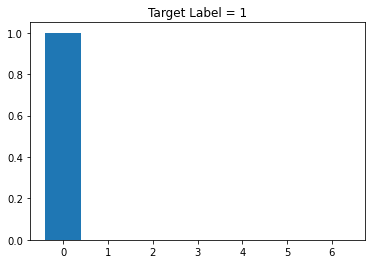

In [147]:
import matplotlib.pyplot as plt

# Initialize misclassified_index to -1 (indicating no misclassification found)
misclassified_index = -1

# Loop through predictions and find the first misclassified sample
for i in range(len(pred)):
    if pred[i] != y_test[i]:
        misclassified_index = i
        break

# Checking  if any misclassification was found
if misclassified_index != -1:
    # Get the class probabilities for the misclassified example
    misclassified_probs = output[misclassified_index].detach().numpy()

    # Plotting the bar graph for class probabilities
    plt.bar(range(7), misclassified_probs)
    plt.title('Target Label = {}'.format(int(y_test[misclassified_index])))
    plt.show()
else:
    print("No misclassified examples found.")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


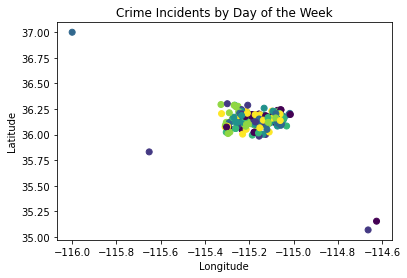

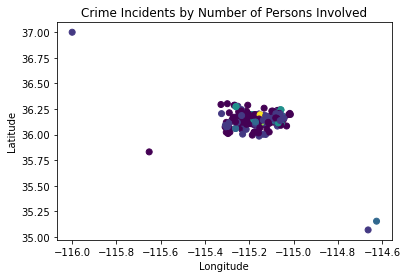

Thursday 51
Wednesday 44
Friday 43
Sunday 40
Monday 37
Tuesday 32
Saturday 28


In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Scatter plot based on day of the week
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis')
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Scatter plot based on the number of persons involved
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis')
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

day_names = {
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday',
    3: 'Wednesday', 4: 'Thursday', 5: 'Friday',
    6: 'Saturday'
}

crime_counts = df['DayOfWeek'].map(day_names).value_counts().reset_index()
crime_counts.columns = ['DayName', 'Count']

# Sort the counts in descending order
sorted_crime_counts = crime_counts.sort_values(by='Count', ascending=False)

# Print the sorted counts
for row in sorted_crime_counts.itertuples(index=False):
    print(row.DayName, row.Count)

